# Heart Disease Classification

## Introduction:

Heart disease is a prevalent health risk and one of the single largest causes of death in the world. Understanding how certain health factors affect the diagnosis of heart disease is important for understanding how to prevent heart disease. This data set (processed Cleveland data) includes observations of the age, sex, and results of many medical tests for people with and without heart disease.

The predictor variables we are interested in for this project are:
age - age of the patient in years
chol - serum cholesterol of the patient in mg/dl
thalach - maximum heart rate achieved in bpm
oldpeak - ST depression induced by exercise relative to rest
ca - number of major vessels (0-3) coloured by flourosopy

The target variable we are interested in predicting is “num”. This dataset only concentrates on whether heart disease is present (values 1,2,3,4) or absent (value 0). Therefore, we have coded all non zero values as a positive diagnosis and zero as a negative diagnosis for heart disease. This data set includes 297 entries in total.

**Research question: Based on the age, chol, thalach, oldpeak, and ca variables for a patient, can we accurately predict whether or not they will receive a heart disease diagnosis.**


**Method**

We will make a k-nn classification model to predict whether or not a person will have a diagnosis of heart 
disease based on these predictor variables: age, chol, thalach, oldpeak, and ca. We will tune our classifier by
cross-validating our data to determine the K-value that will give us the best accuracy, then make a new
classification model using this K-value.

We will visualize the results by making scatterplots/barplots for different variables to observe the effect of their values on our response variable: the heart disease diagnosis.


**What do you expect to find?**

We want to find which variables will cause the diagnosis of heart disease. We expect that older age, higher cholesterol, higher ST depression induced by exercise, and higher number of major vessels coloured by fluoroscopy will be correlated with a diagnosis of heart disease, and that a lower maximum heart rate achieved will be correlated with a diagnosis of heart disease. We believe we will be able to make an accurate enough model to diagnose patients based on their medical information.

**What impact could such findings have?**

Our model will help us identify which patients are predicted to be having heart disease. Using this information, we can identify patients who needs immediate medical attention to prevent potentially life threatening situations like a heart attack from occurring. Preventive measures can be performed by a doctor upon this predictive diagnosis. This could possibly save a patient's life. 

**What future questions could this lead to?**

- What are the specific clinical scenarios or patient populations for which the model is most beneficial?
- Why is a certain variable correlated with a positive heart disease diagnosis? 
- How can we use these findings to prevent heart disease?
- How can we use data analysis to predict those who are at risk for heart disease?
- How can the quality and quantity of data used for model development be improved to enhance prediction accuracy?

In [44]:
library(tidyverse)
library(tidymodels)
library(dplyr)
library(repr)
install.packages("kknn")
install.packages("cowplot")
library(cowplot)
library(kknn)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [45]:
set.seed(9999)

In [72]:
# Loaded data set and omitted N/A values

url <- "https://archive.ics.uci.edu/static/public/45/data.csv"
heart <-  read_csv(url)
heart <- na.omit(heart)
head(heart)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (14): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
41,0,2,130,204,0,2,172,0,1.4,1,0,3,0
56,1,2,120,236,0,0,178,0,0.8,1,0,3,0


In [47]:
# In the Cleveland dataset, any occurance of "num" other than 0 is considered a presence of heart disease
heart$num <- ifelse(heart$num >= 1 & heart$num <= 4, "yes", "no")

# Making num a factor variable
heart <- heart |>
        mutate(num = as_factor(num))
head(heart)

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,no
67,1,4,160,286,0,2,108,1,1.5,2,3,3,yes
67,1,4,120,229,0,2,129,1,2.6,2,2,7,yes
37,1,3,130,250,0,0,187,0,3.5,3,0,3,no
41,0,2,130,204,0,2,172,0,1.4,1,0,3,no
56,1,2,120,236,0,0,178,0,0.8,1,0,3,no


In [48]:
# Separating data into training and testing sets
heart_split <- initial_split(heart, prop = 0.75, strata = num)
heart_training <- training(heart_split)
heart_testing <- testing(heart_split)

In [49]:
# Seeing number of occurances of each class of our target variable "num"
distribution <- heart_training |>
                group_by(num) |>
                summarize(count = n())

print("Table: Distribution of Positive and Negative Diagnosis In Training Data")
distribution

[1] "Table: Distribution of Positive and Negative Diagnosis In Training Data"


num,count
<fct>,<int>
no,120
yes,102


In [50]:
# Making a table of means of each predictor, based on diagnosis

mean_chol <- heart_training |>
            group_by(num) |>
            summarize(chol = mean(chol))
mean_age <- heart_training |>
            group_by(num) |>
            summarize(age = mean(age))
mean_thalach <- heart_training |>
                group_by(num) |>
                summarize(thalach = mean(thalach))
mean_oldpeak <- heart_training |>
                group_by(num) |>
                summarize(oldpeak = mean(oldpeak))
mean_ca <- heart_training |>
                group_by(num) |>
                summarize(ca = mean(ca))

print("Average predictor value with and without heart disease diagnosis")
combined_means <- bind_rows(mean_chol, mean_age, mean_thalach, mean_oldpeak, mean_ca) |>
                    pivot_longer(cols = chol:ca,
                                names_to = "predictor_name",
                                values_to = "predictor_mean") |>
                    na.omit() |>
                    rename("heart_disease" = "num")
combined_means


[1] "Average predictor value with and without heart disease diagnosis"


heart_disease,predictor_name,predictor_mean
<fct>,<chr>,<dbl>
no,chol,242.9250000
yes,chol,254.0686275
no,age,52.2166667
yes,age,57.6372549
no,thalach,158.0750000
yes,thalach,138.8627451
no,oldpeak,0.6233333
yes,oldpeak,1.7058824
no,ca,0.3166667


Warning message in as_grob.default(plot):
“Cannot convert object of class numeric into a grob.”


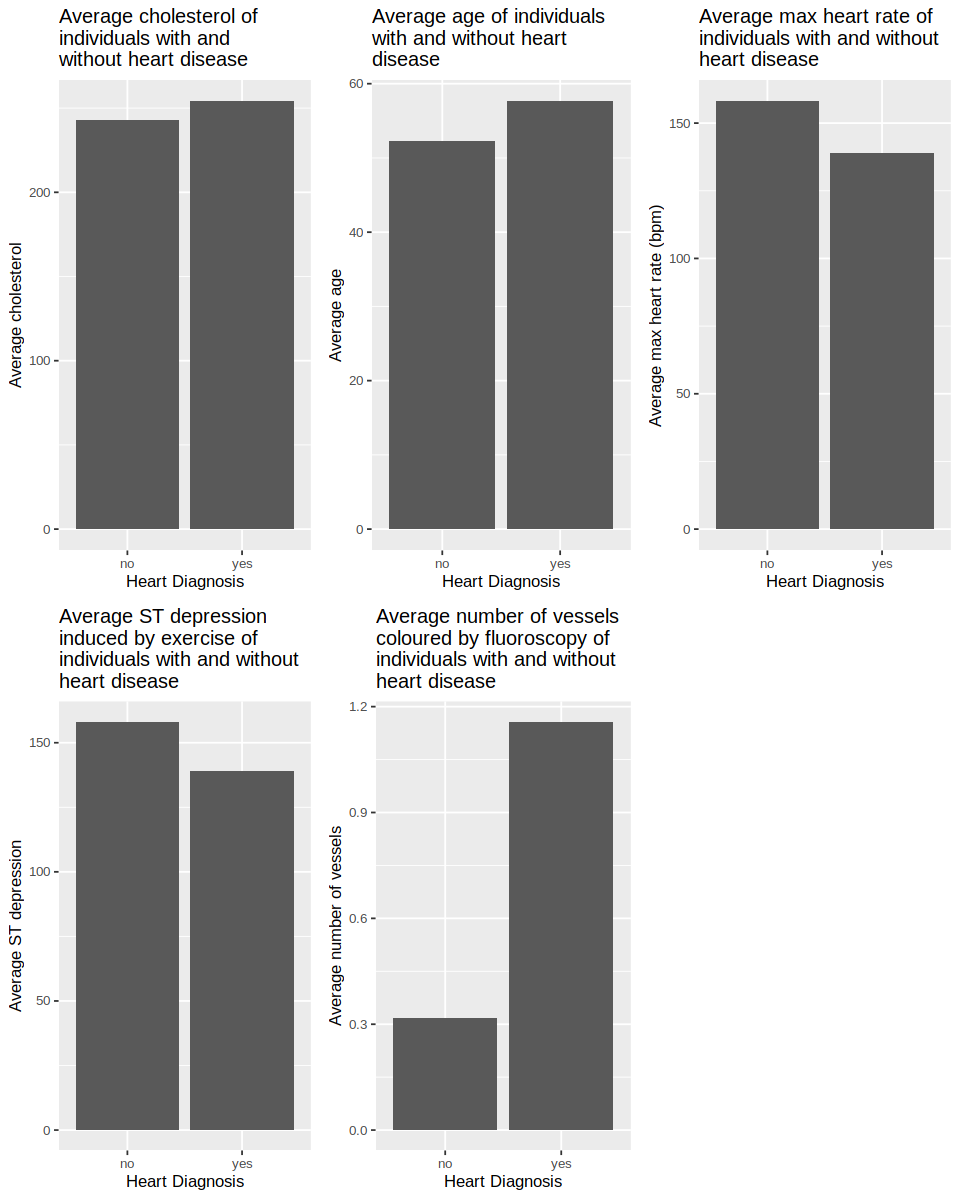

In [70]:
# Graphing the table above to compare diagnosis/no diagnosis averages for each predictor

options(repr.plot.width = 8, repr.plot.height = 10)

chol_avg <- combined_means |>
filter(predictor_name == "chol")

chol_var <- chol_avg |>
ggplot(aes(x = heart_disease, y = predictor_mean)) +
geom_bar(stat = "identity") +
labs(x = "Heart Diagnosis",
     y = "Average cholesterol",
    fill = "Heart Disease") +
theme(text = element_text(size = 10)) +
ggtitle("Average cholesterol of\nindividuals with and\nwithout heart disease")



age_avg <- combined_means |>
filter(predictor_name == "age")

age_var <- age_avg |>
ggplot(aes(x = heart_disease, y = predictor_mean)) +
geom_bar(stat = "identity") +
labs(x = "Heart Diagnosis",
     y = "Average age",
    fill = "Heart Disease") +
theme(text = element_text(size = 10)) +
ggtitle("Average age of individuals\nwith and without heart\ndisease")



thalach_avg <- combined_means |>
filter(predictor_name == "thalach")

thalach_var <- thalach_avg |>
ggplot(aes(x = heart_disease, y = predictor_mean)) +
geom_bar(stat = "identity") +
labs(x = "Heart Diagnosis",
     y = "Average max heart rate (bpm)",
    fill = "Heart Disease") +
theme(text = element_text(size = 10)) +
ggtitle("Average max heart rate of\nindividuals with and without\nheart disease")



oldpeak_avg <- combined_means |>
filter(predictor_name == "oldpeak")

oldpeak_var <- thalach_avg |>
ggplot(aes(x = heart_disease, y = predictor_mean)) +
geom_bar(stat = "identity") +
labs(x = "Heart Diagnosis",
     y = "Average ST depression",
    fill = "Heart Disease") +
theme(text = element_text(size = 10)) +
ggtitle("Average ST depression\ninduced by exercise of\nindividuals with and without\nheart disease")



ca_avg <- combined_means |>
filter(predictor_name == "ca")

ca_var <- ca_avg |>
ggplot(aes(x = heart_disease, y = predictor_mean)) +
geom_bar(stat = "identity") +
labs(x = "Heart Diagnosis",
     y = "Average number of vessels",
    fill = "Heart Disease") +
theme(text = element_text(size = 10)) +
ggtitle("Average number of vessels\ncoloured by fluoroscopy of\nindividuals with and without\nheart disease")


plot_grid(chol_var, age_var, thalach_var, oldpeak_var, ca_var, nrows = 3)

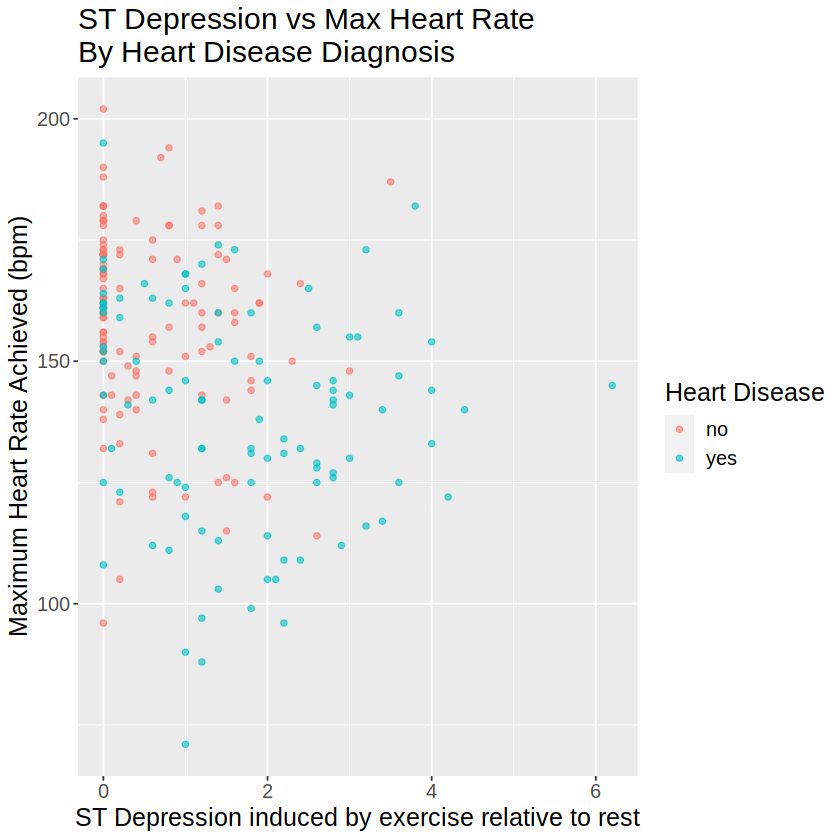

In [52]:
# Plotting cholesterol levels vs maximum heart rate achieved

# Converting "num" to a factor
heart_training$num <- as.factor(heart_training$num)

chol_vs_heart <- heart_training |>
    ggplot(aes(x = oldpeak, y = thalach, color = num)) +
    geom_point(alpha = 0.6) +
    labs(x = "ST Depression induced by exercise relative to rest",
         y = "Maximum Heart Rate Achieved (bpm)", color = "Heart Disease") +
    theme(text = element_text(size = 15)) +
    ggtitle("ST Depression vs Max Heart Rate\nBy Heart Disease Diagnosis")

chol_vs_heart


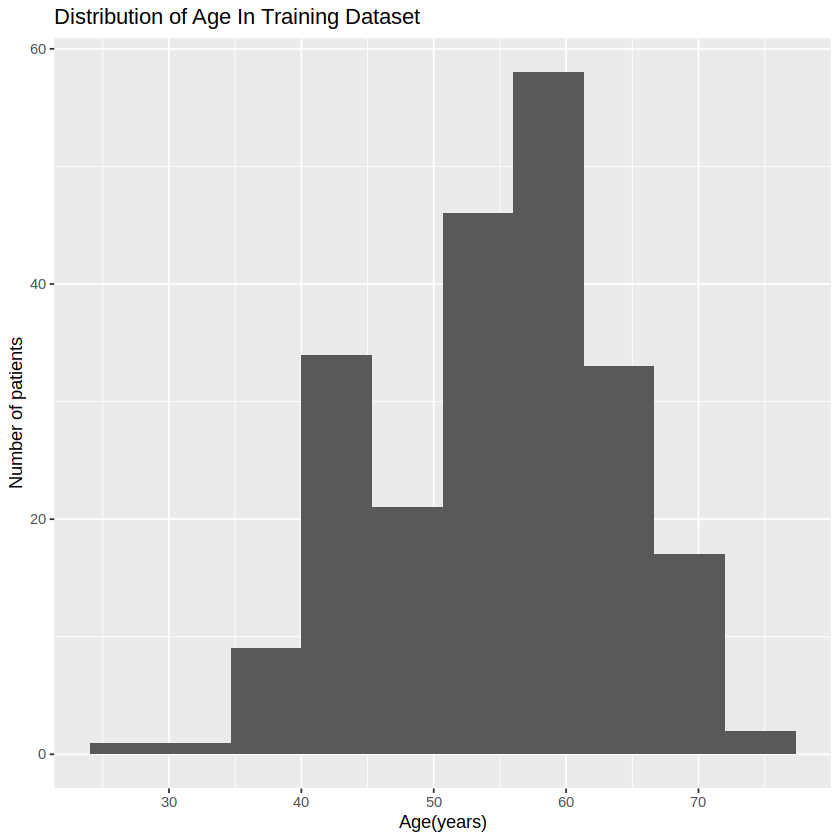

In [53]:
agedistribution <- heart_training |>
ggplot(aes(x = age)) +
geom_histogram(bins = 10) +
labs(x = "Age(years)", y = "Number of patients") +
ggtitle("Distribution of Age In Training Dataset")
agedistribution

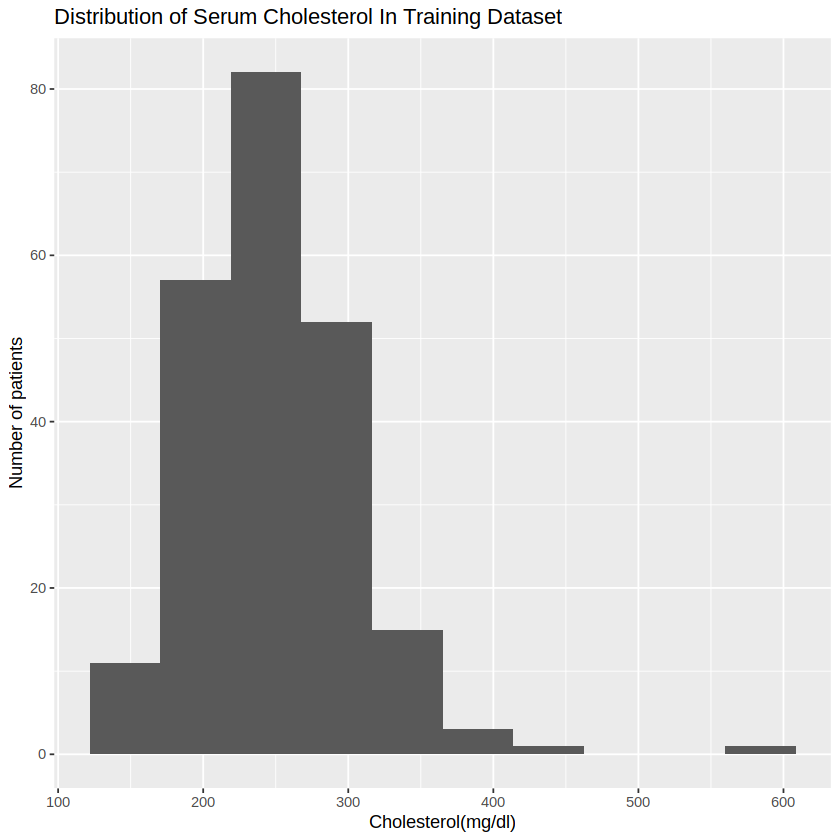

In [54]:
choldistribution <- heart_training |>
ggplot(aes(x = chol)) +
geom_histogram(bins = 10) +
labs(x = "Cholesterol(mg/dl)", y = "Number of patients") +
ggtitle("Distribution of Serum Cholesterol In Training Dataset")
choldistribution

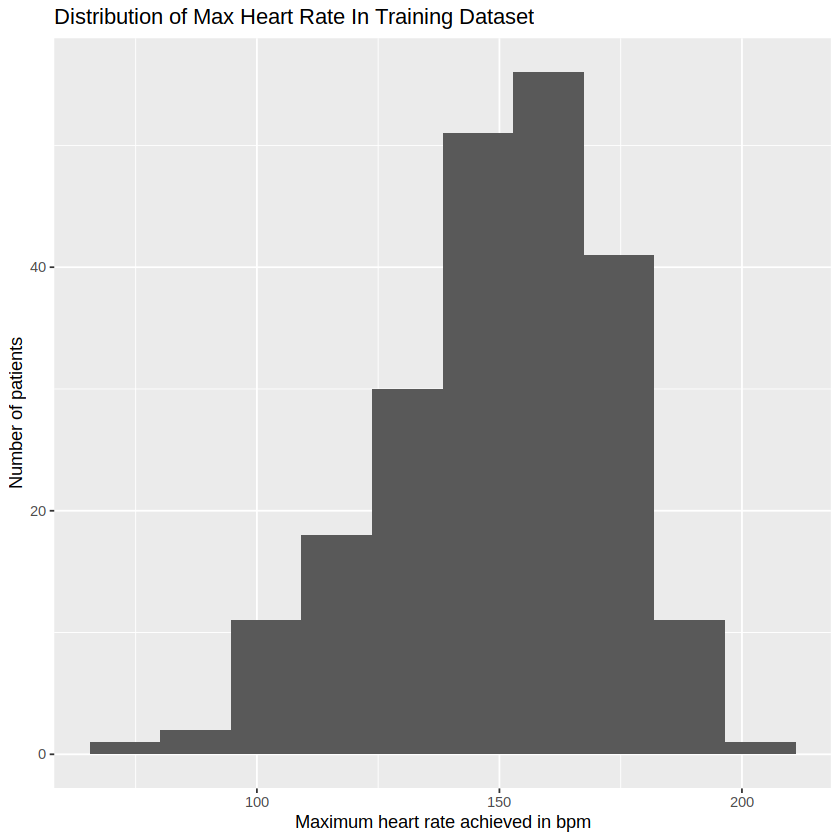

In [55]:
thalachdistribution <- heart_training |>
ggplot(aes(x = thalach)) +
geom_histogram(bins = 10) +
labs(x = "Maximum heart rate achieved in bpm", y = "Number of patients") +
ggtitle("Distribution of Max Heart Rate In Training Dataset")
thalachdistribution

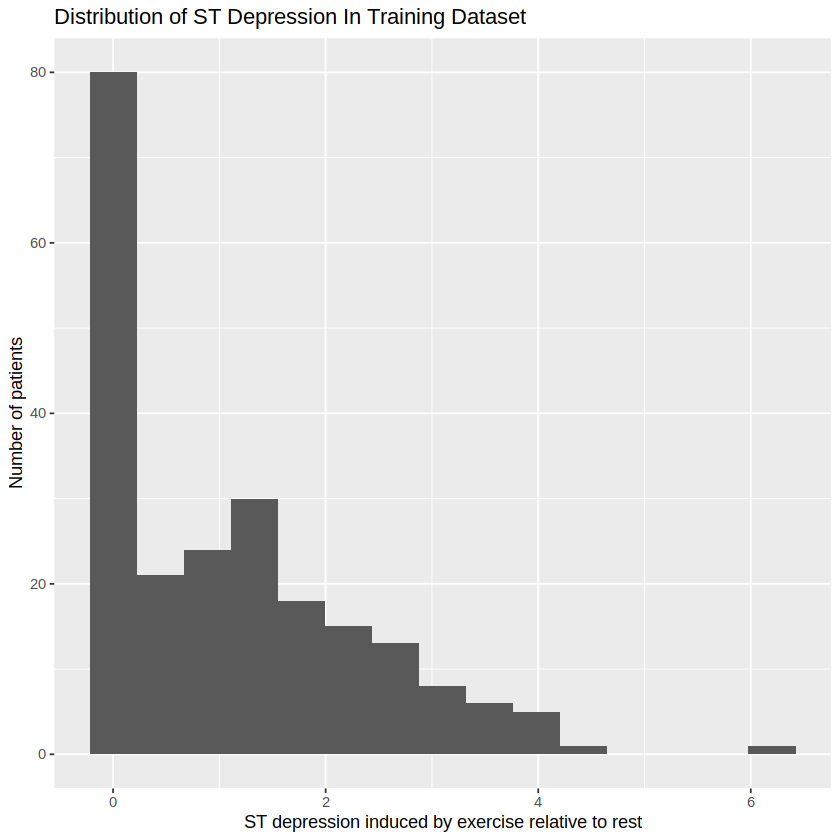

In [56]:
oldpeakdistribution <- heart_training |>
ggplot(aes(x = oldpeak)) +
geom_histogram(bins = 15) +
labs(x = "ST depression induced by exercise relative to rest", y = "Number of patients") +
ggtitle("Distribution of ST Depression In Training Dataset")
oldpeakdistribution


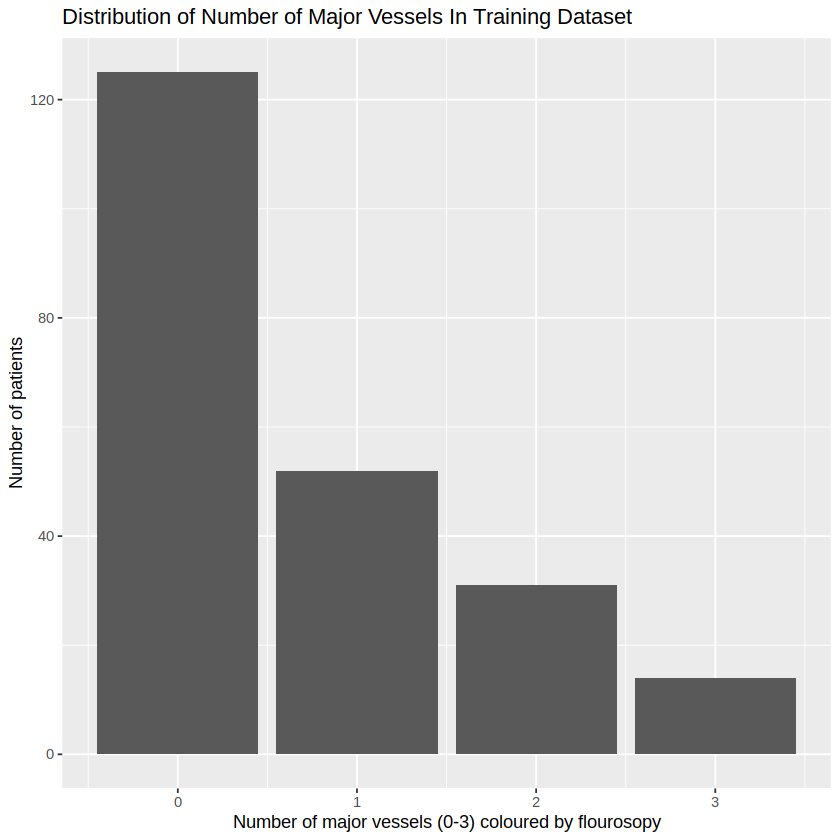

In [57]:
cadistribution <- heart_training |>
ggplot(aes(x = ca)) +
geom_bar() +
labs(x = "Number of major vessels (0-3) coloured by flourosopy", y = "Number of patients") +
ggtitle("Distribution of Number of Major Vessels In Training Dataset")
cadistribution

In [58]:
# created a range of values for k
k_vals <- tibble(neighbors = seq(1, 100, 5))

In [19]:
# created a vfold of 5 folds
heart_vfold <- vfold_cv(heart_training, v = 5, strata = num)

In [20]:
# created model for tuning
tune_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

# created recipe using subtrain data
heart_recipe <- recipe(num ~ age + chol + thalach + oldpeak + ca,
                 data = heart_training) |>
            step_scale(all_predictors()) |>
            step_center(all_predictors())

In [21]:
# combined the model and recipe into a workflow and fit with subtrain data
cv_workflow <- workflow() |>
                add_recipe(heart_recipe) |>
                add_model(tune_spec) |>
                tune_grid(resamples = heart_vfold, grid = k_vals) |>
                collect_metrics() |>
                filter(.metric == "accuracy")

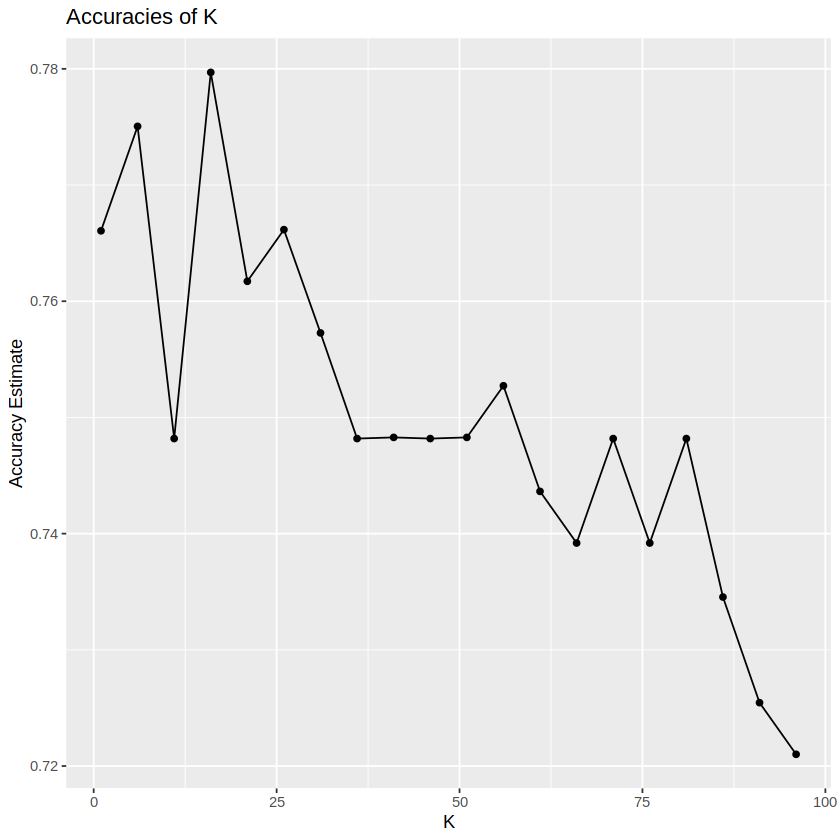

In [22]:
# Graphing the k-values with their accuracy
k_vals_accuracy_plot <- cv_workflow |>
                        ggplot(aes(x = neighbors, y = mean)) +
                        geom_point() +
                        geom_line() +
                        labs(x = "K", y = "Accuracy Estimate") +
                        ggtitle("Accuracies of K")
k_vals_accuracy_plot


In [23]:
# choosing the best k-value based on accuracy

best_k <- cv_workflow |>
            slice_max(mean) |>
            pull(neighbors)
best_k

[1] 16

In [24]:
# After choosing the best k-value for our model, we make a model using that k value

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
            set_engine("kknn") |>
            set_mode("classification")

In [27]:
# we fit our new model to the heart training data using a workflow

new_fit <- workflow() |>
                add_recipe(heart_recipe) |>
                add_model(knn_spec) |>
                fit(heart_training) 

In [28]:
# we check this model's accuracy using our testing dataset

heart_disease_predictions <- predict(new_fit, heart_testing) |>
                            bind_cols(heart_testing)
head(heart_disease_predictions)

.pred_class,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
yes,67,1,4,160,286,0,2,108,1,1.5,2,3,3,yes
no,57,0,4,120,354,0,0,163,1,0.6,1,0,3,no
yes,63,1,4,130,254,0,2,147,0,1.4,2,1,7,yes
no,44,1,2,120,263,0,0,173,0,0.0,1,0,7,no
no,52,1,3,172,199,1,0,162,0,0.5,1,0,7,no
no,57,1,3,150,168,0,0,174,0,1.6,1,0,3,no


In [29]:
# Testing our final model accuracy using our testing data
model_accuracy <- heart_disease_predictions |>
                    metrics(truth = num, estimate = .pred_class) |>
                    filter(.metric == "accuracy")
model_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7333333


In [30]:
# Confusion matrix

confusion <- heart_disease_predictions |>
            conf_mat(truth = num, estimate = .pred_class)
confusion

          Truth
Prediction no yes
       no  36  16
       yes  4  19

## Conclusion: 

The confusion matrix above gives us more insight about the usefulness of our model than the accuracy measured above. Our positive result is a "yes" diagnosis (indicating the presence of heart disease), while our negative result is a "no" diagnosis (indicating an absence of heart disease). The confusion matrix tells us that our model has a precision of 19/23 ~ 82.6%. On the other hand, it has a recall of 19/35 ~ 54.29%. This is not good! This suggests that given a patient has heart disease, our model is only able to predict this about 54.29% of the time! We can therefore conclude that this model is not safe to use in a real-world scenario. The inability to diagnose a heart disease patient could prove fatal since an accurate and timely diagnosis is needed to prevent a heart attack.  

Possible reasons for why we couldn't create a useful model could include our small dataset size. We only had 297 data entries in total, and only 75% of that was used for training our model. This appears to not have been enough to train the model properly. 

Another reason could have been that the wrong predictor variables were chosen. Perhaps using more/less variables could have yielded a better model. 

To summarize, this model is not useful since its recall is quite low. This low recall value is highly dangerous in the real world since we don't want to be misdiagnosing patients who have heart disease as this can be fatal.

In [35]:

mean_pred_chol <- heart_disease_predictions |>
            group_by(.pred_class) |>
            summarize(chol = mean(chol))
mean_pred_age <- heart_disease_predictions |>
            group_by(.pred_class) |>
            summarize(age = mean(age))
mean_pred_thalach <- heart_disease_predictions |>
                group_by(.pred_class) |>
                summarize(thalach = mean(thalach))
mean_pred_oldpeak <- heart_disease_predictions |>
                group_by(.pred_class) |>
                summarize(oldpeak = mean(oldpeak))
mean_pred_ca <- heart_disease_predictions |>
                group_by(.pred_class) |>
                summarize(ca = mean(ca))

print("Final model's average predictor values with and without heart disease diagnosis")
pred_combined_means <- bind_rows(mean_pred_chol, mean_pred_age, mean_pred_thalach, mean_pred_oldpeak, mean_pred_ca)|>
                    pivot_longer(cols = chol:ca,
                                names_to = "predictor_name",
                                values_to = "predictor_mean") |>
                    na.omit() |>
                    rename("heart_disease_prediction" = ".pred_class")
pred_combined_means

[1] "Final model's average predictor values with and without heart disease diagnosis"


heart_disease_prediction,predictor_name,predictor_mean
<fct>,<chr>,<dbl>
no,chol,242.7500000
yes,chol,251.0434783
no,age,51.9038462
yes,age,58.9130435
no,thalach,158.3846154
yes,thalach,133.1304348
no,oldpeak,0.3807692
yes,oldpeak,1.9521739
no,ca,0.2115385
